In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import string

from collections import defaultdict

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl
import regex as re

In [0]:
from time import time

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`
 
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.grid(b=None)

In [0]:
def split_into_subwords_function(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            if subword in word:
                word = word.replace(subword, ' ')
                subwords.append(subword)
    return ' '.join(subwords)

In [0]:
def preprocess_function(text):
    # removes punctuation from a string, and converts all characters to lowercase
    
    punctuation_without_hyphen = ''.join([x for x in string.punctuation if x != '-'])
    translation_table = str.maketrans('\n-', '  ', punctuation_without_hyphen+string.digits)
    return text.translate(translation_table).lower()

## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazyk_(jazykoveda))
Jazyk je historicky konštruovaný systém zvukových, lexikálnych a gramatických prostriedkov, objektivizujúci prácu myslenia, komunikácie a vzájomného chápania sa jej účastníkov. Jeho skúmaním sa zaoberá špecifická oblasť kognitívnej aktivity človeka - jazykoveda. Jeho praktickou realizáciou je reč. Základnými funkciami jazyka sú: dorozumievacia – komunikatívna, poznávacia – kognitívna, estetická a reprezentatívna. 

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jazyk_(lingvistika))
Jazyk je systém sloužící jako základní prostředek lidské komunikace. Kromě funkce dorozumívací může plnit další funkce, např. apelovou (může sloužit k předávání příkazů), referenční (odkazuje se na časové nebo prostorové vztahy), kontaktovou, expresivní (emotivní), estetickou (poetickou) a metajazykovou.
Odhadovaný počet jazyků na světě kolísá mezi pěti a sedmi tisíci. V mnoha případech je obtížné rozlišit mezi jazykem a dialektem; přesný odhad je tedy závislý na použitých metodách či stanovených kritériích. Akademikové se shodují, že do konce tohoto století vymizí na padesát až devadesát procent současných živých jazyků.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Language)
A language is a structured system of communication. Language, in a broader sense, is the method of communication that involves the use of – particularly human – languages. The scientific study of language is called linguistics. Questions concerning the philosophy of language, such as whether words can represent experience, have been debated at least since Gorgias and Plato in ancient Greece.


## [Ukrainian Wikipedia Entry](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B2%D0%B0)
Мова — система звукових і графічних знаків, що виникла на певному рівні розвитку людства, розвивається і має соціальне призначення; правила мови нормалізують використання знаків та їх функціонування як засобів людського спілкування. Мова — це найважливіший засіб спілкування і пізнання. Розрізняють людську, формальну і тваринну мови. Наука, яка займається вивченням мови називається мовознавством або лінгвістикою. 


## [Russian Wikipedia Entry](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B2%D0%B0)
Язы́к — сложная знаковая система, естественно или искусственно созданная и соотносящая понятийное содержание и типовое звучание (написание).
Термин «язык», понимаемый в широком смысле, может применяться к произвольным знаковым системам, хотя чаще он используется для более узких классов знаковых систем. 


# Data Uploading, Cleaning and Preprocessing

In [0]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [0]:
data_raw = {}
data_raw['ru']= open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/train_sentences.ru.txt')[:100]
data_raw['uk']= open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/train_sentences.uk.txt')[:100]
data_raw['sk']= open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/train_sentences.sk')[:100]
data_raw['cs']= open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/train_sentences.cs')[:100]
data_raw['en']= open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/train_sentences.en')[:100]

In [0]:
print(data_raw['uk'][:5])

["Перелякані мешканці дому з'юрмилися на горішній площадці сходів.\n", 'Знизу, наче з чорної прірви, долинали якісь булькітливі звуки, так, немов із води виходило повітря.\n', 'Часом ті звуки перетворювалися в шипіння, трохи чи не в свист.\n', 'Але й це незабаром стихло, і в мороці чулося вже тільки важке дихання, ніби хтось насилу зводив дух.\n', 'Відон Скотт натиснув на кнопку, і світло залляло сходи й передпокій унизу Він і його батько, з револьверами в руках, обережно зійшли сходами.\n']


In [0]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        word_list = ' '.join(sentences).split()
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ' '.join(sentences[0].split()[0:7])

        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [0]:
def preprocess(text):
    # Removes punctuation and digits from a string, and converts all characters to lowercase.        
    preprocessed_text = text
    preprocessed_text = text.lower().replace('-', ' ')
    preprocessed_text = re.sub('[^\s\w]','', preprocessed_text)
        
    return preprocessed_text

In [0]:
data_preprocessed= {k: [preprocess(sentence) for sentence in v] for k,v in data_raw.items()}

In [0]:
print('Statistics over raw data')
show_statistics(data_raw)

print('****************************************\nStatistics over preprocessed data')
show_statistics(data_preprocessed)

Statistics over raw data
Language: ru
-----------------------
Number of sentences	:	 100
Number of words		:	 1941
Number of unique words	:	 1322
Sample extract		:	 читать онлайн книги бесплатно...

Language: uk
-----------------------
Number of sentences	:	 100
Number of words		:	 1241
Number of unique words	:	 791
Sample extract		:	 Перелякані мешканці дому з'юрмилися на горішній площадці...

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...

****************************************
Statis


# Using Naive Bayes Model

A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem.

Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.

In [0]:
sentences_train, y_train = [],[]

for k,v in data_preprocessed.items():
  for sentence in v:
    sentences_train.append(sentence)
    y_train.append(k)

In [0]:
vectorizer = CountVectorizer()

In [0]:
X_train = vectorizer.fit_transform(sentences_train)

In [0]:
X_train

<410x4109 sparse matrix of type '<class 'numpy.int64'>'
	with 6696 stored elements in Compressed Sparse Row format>

In [0]:
naive_classifier= MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
data_val = {}
data_val['sk'] = open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/val_sentences.sk')[:5000]
data_val['cs'] = open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/val_sentences.cs')[:5000]
data_val['en'] = open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/val_sentences.en')[:5000]
data_val['uk'] = open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/val_sentences.uk.txt')[:5000]
data_val['ru'] = open_file('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/val_sentences.ru.txt')[:5000]

data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k,v in data_val.items()}

In [0]:
print(data_val_preprocessed)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
sentences_val, y_val = [],[]
for k,v in data_val_preprocessed.items():
  for sentence in v:
    sentences_val.append(sentence)
    y_val.append(k)

In [0]:
X_val = vectorizer.transform(sentences_val)

In [0]:
predictions = naive_classifier.predict(X_val)

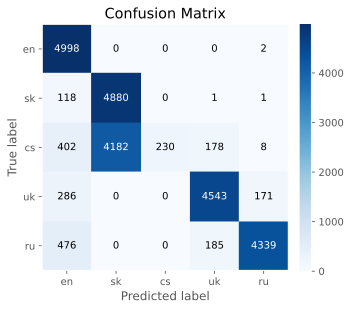

In [0]:
plot_confusion_matrix(y_val, predictions, ['en','sk', 'cs', 'uk', 'ru'])

In [0]:
f1_score(y_val, predictions, average = 'weighted')

0.6993563258010779

The model gives amazing results for the English language, quite good for Ukrainian and Russian (which is great because these languages are quite similar and have almost the same letters; sometimes even for native speakers it is not obvious which language is it), the Czech language is almost completely classified as Slovak. This is obviously caused by the size of the dataset and will be fixed.

F1-score (harmonic mean of the precision and recall) is 69.9% which is caused by wrong classification of Czech.


# Parameters

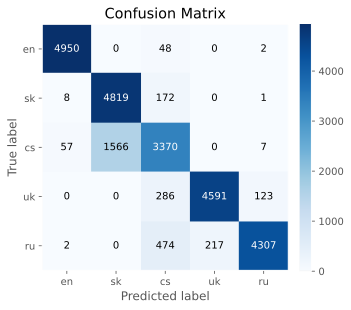

In [0]:
naive_classifier = MultinomialNB(alpha=0.01, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions =naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['en','sk', 'cs', 'uk', 'ru'])

In [0]:
f1_score(y_val, predictions, average = 'weighted')

0.8808805007878721


Tuning of the parameters alpha, fit_prior let us get f1-score 88,1%. 
Where *alpha* is smoothing parameter and *fit_prior* parameter lets conrol whether to learn class prior probabilities or not. If false, a uniform prior will be used. So this option gives us better results.

This method helped us to get a better performance on the language that has the least size (only 10 sentenses, meanwhile other languages have 10 times more). 



# Subwords Method

**Neural Machine Translation of Rare Words with Subword Units**

(https://arxiv.org/abs/1508.07909)

Neural machine translation (NMT) models typically operate with a fixed vocabulary, but translation is an open-vocabulary problem. Previous work addresses the translation of out-of-vocabulary words by backing off to a dictionary. In this paper, introduced a simpler and more effective approach, making the NMT model capable of open-vocabulary translation by encoding rare and unknown words as sequences of subword units. This is based on the intuition that various word classes are translatable via smaller units than words, for instance names (via character copying or transliteration), compounds (via compositional translation), and cognates and loanwords (via phonological and morphological transformations). We discuss the suitability of different word segmentation techniques, including simple character n-gram models and a segmentation based on the byte pair encoding compression algorithm, and empirically show that subword models improve over a back-off dictionary baseline for the WMT 15 translation tasks English-German and English-Russian by 1.1 and 1.3 BLEU, respectively. 


So I am using this approach of subwords for this purpose.

Unfortunately, there is no reason to use Czech for this training. The algorithm requires morphemes sorted in the order from most to less used for the particular language. Having not enough morphemes for Czech, we cannot use it in this algorithm.

In [0]:
data_raw.pop('cs')

In [0]:
data_preprocessed= {k: [preprocess(sentence) for sentence in v] for k,v in data_raw.items()}

sentences_train, y_train = [],[]

for k,v in data_preprocessed.items():
  for sentence in v:
    sentences_train.append(sentence)
    y_train.append(k)

In [0]:
data_val.pop('cs')

In [0]:
data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k,v in data_val.items()}

sentences_val, y_val = [],[]

for k,v in data_val_preprocessed.items():
  for sentence in v:
    sentences_val.append(sentence)
    y_val.append(k)

In [0]:
# taken from original paper
import collections
def get_stats(vocab):
  # returns dict of every possible combination of two letters with frequencies 
  # 'model is odd' -> { 'mo':1, 'od':2, 'de':1 ...}
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [0]:
def get_vocab(data):
#returns words separated by ' '
    words = []
    for sentence in data:
        words.extend(sentence.split())
        print(words)
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [0]:
vocab = get_vocab(sentences_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# also taken from original paper
for i in range(200):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [0]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [0]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [0]:
pkl.dump(merge_ordered, open('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/merge_ordered.pkl', 'wb'))

In [0]:
def split_into_subwords(text):
    merges = pkl.load(open('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges: 
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [0]:
split_into_subwords('однажды весною в час небывало жаркого заката в москве на патриарших прудах появились два гражданина')

'на но ве ча не ло ва бы ко го ка та за ве мо на ри па ши да ру ли по ви сь ва на ни ра да'

In [0]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [0]:
show_statistics(data_preprocessed_subwords)

Language: ru
-----------------------
Number of sentences	:	 100
Number of words		:	 4089
Number of unique words	:	 76
Sample extract		:	 та ть чи ла ни но ла...

Language: uk
-----------------------
Number of sentences	:	 100
Number of words		:	 2027
Number of unique words	:	 76
Sample extract		:	 ре ка пе ля ні ка ме...

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3409
Number of unique words	:	 75
Sample extract		:	 de an de al as ne as...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 3888
Number of unique words	:	 76
Sample extract		:	 an st an er ou ro ch...



In [0]:
data_train_subwords = []
for sentence in sentences_train:
  data_train_subwords.append(split_into_subwords(sentence))

In [0]:
data_val_subwords = []
for sentence in sentences_val:
  data_val_subwords.append(split_into_subwords(sentence))

In [0]:
vectorizer = CountVectorizer()

In [0]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [0]:
naive_classifier = MultinomialNB(fit_prior=False, alpha=0.01)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

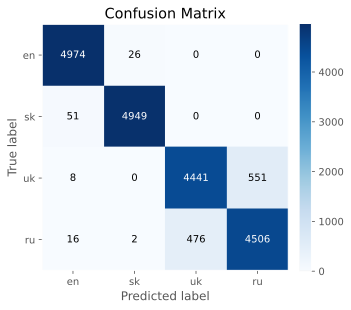

In [0]:
plot_confusion_matrix(y_val, predictions, ['en','sk','uk', 'ru'])

In [0]:
f1_score(y_val, predictions, average = 'weighted')

0.9434392677604612

Using subwords is useful because it breaks up incoming words, that the model has not seen during training at all, into subwords units is maybe has seen.
If you never have the word playing in your training data, your vectorizer will simply discard of the word. If however, it is borken down into the subwords play and ing, which your training data is much likelier to have seen, this data will not be discarded.


This method gave us f1-score of 94.3% which is not bad taking into account simple models, the ridiculous time needed for training, and comparably small train datasets. Also, the similarities between Ukrainian and Russian should be taken into account. 

After adding 90 more training examples to the Czech language the algorithm classifies that languages almost as successful as Ukrainian/Russian.


# Three not related languages (English, Slovak, Ukrainian)

In [0]:
data_raw.pop('ru')

In [0]:
data_preprocessed= {k: [preprocess(sentence) for sentence in v] for k,v in data_raw.items()}

sentences_train, y_train = [],[]

for k,v in data_preprocessed.items():
  for sentence in v:
    sentences_train.append(sentence)
    y_train.append(k)

In [0]:
data_val.pop('ru')

In [0]:
data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k,v in data_val.items()}

sentences_val, y_val = [],[]

for k,v in data_val_preprocessed.items():
  for sentence in v:
    sentences_val.append(sentence)
    y_val.append(k)

In [0]:
vocab = get_vocab(sentences_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# also taken from original paper
for i in range(200):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [0]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [0]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [0]:
pkl.dump(merge_ordered, open('/content/drive/My Drive/Colab Notebooks/course/Language Classification Project/files/merge_ordered.pkl', 'wb'))

In [0]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [0]:
data_train_subwords = []
for sentence in sentences_train:
  data_train_subwords.append(split_into_subwords(sentence))

In [0]:
data_val_subwords = []
for sentence in sentences_val:
  data_val_subwords.append(split_into_subwords(sentence))

In [0]:
vectorizer = CountVectorizer()

In [0]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [0]:
naive_classifier = MultinomialNB(fit_prior=False, alpha=0.01)

time_start = time()
naive_classifier.fit(X_train, y_train)
time_end = time()
print('Time needed for fitting = ', time_end-time_start)

predictions = naive_classifier.predict(X_val)

Time needed for fitting =  0.0038645267486572266


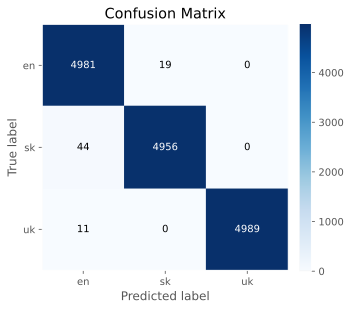

In [0]:
plot_confusion_matrix(y_val, predictions, ['en','sk','uk'])

In [0]:
f1_score(y_val, predictions, average = 'weighted')

0.9950698478779552

As a result:
99.5% is estimated (neither by me nor, unfortunately, by the official sources) to be the accuracy of Google language detector. 
So the results 99.5% for not related languages are quite good. 
Results for the related languages is 94.3% can be explained by many factors. For example, sometimes in the literature, we can meet so-called "russism", when Russian words are used as Ukrainian. Also, a lot of words are formed with the same morphemes.

For these small training sets (100 for most languages, 10 for Czech) and not computation consuming algorithms the training time is as small as possible (0.0038s)

For 'fighting' with small datasets, we can use changing the parameters and using uniform prior probabilities.